In [1]:
import numpy as np
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations 
from scipy import io
import pandas as pd
import palettable 


In [2]:
def task_ind(task, a_pokes, b_pokes): 
    """ Create Task IDs for that are consistent: in Task 1 A and B at left right extremes, in Task 2 B is one of the diagonal ones, 
    in Task 3  B is top or bottom """
    taskid = np.zeros(len(task));
    taskid[b_pokes == 10 - a_pokes] = 1     
    taskid[np.logical_or(np.logical_or(b_pokes == 2, b_pokes == 3), np.logical_or(b_pokes == 7, b_pokes == 8))] = 2  
    taskid[np.logical_or(b_pokes ==  1, b_pokes == 9)] = 3  
    
    return taskid

your_path = '/Users/veronikasamborska/Desktop/' # change path to where github folder is stored on your machine
# load data (for the main figures we used data after removing variance associated with physical movement)
def import_data(your_path):
    HP = io.loadmat(your_path +'notebooks_paper/cells/data_recordings/HP.mat')
    PFC = io.loadmat(your_path + 'notebooks_paper/cells/data_recordings/PFC.mat')
    return HP, PFC

HP, PFC =  import_data(your_path)

In [3]:
def decoder_trial_states(data, task_test = 0, H = 0, perm = True, decoder_full = True):
    '''Simple linear decoding of position in the trial (Initiation, A/B choice/reward/no-reward) 
    using data from one problem, and tested the decoding performance on a different problem (Figure 3F, G).'''
    
    HP_1 = 15; HP_2 = 7 # sessions to split by animals 
    PFC_1 = 9; PFC_2 = 16; PFC_3 = 13
    
    cnf_matrix_subj_x_y = [] # task x to y confusion matrix
    cnf_matrix_subj_y_x = [] # task y to x confusion matrix
   
    if H == 0 and perm == False: # split HP data for each animal
        HP_all_sessions_1 = data['DM'][0][:HP_1]; HP_all_sessions_2 = data['DM'][0][HP_1:HP_1+HP_2]
        HP_all_sessions_3 = data['DM'][0][HP_1+HP_2:]
       
        HP_all_sessions_1_fr = data['Data'][0][:HP_1]; HP_all_sessions_2_fr = data['Data'][0][HP_1:HP_1+HP_2]
        HP_all_sessions_3_fr = data['Data'][0][HP_1+HP_2:]
        
        all_subjects_dm = [HP_all_sessions_1,HP_all_sessions_2, HP_all_sessions_3]
        all_subjects_data = [HP_all_sessions_1_fr,HP_all_sessions_2_fr, HP_all_sessions_3_fr]
        
    elif H != 0 and perm == False: # split PFC data for each animal
        PFC_all_sessions_1 = data['DM'][0][:PFC_1]; PFC_all_sessions_2 = data['DM'][0][PFC_1:PFC_1+PFC_2]
        PFC_all_sessions_3 = data['DM'][0][PFC_1+PFC_2:PFC_1+PFC_2+PFC_3];  PFC_all_sessions_4 = data['DM'][0][PFC_1+PFC_2+PFC_3:]
        
        PFC_all_sessions_1_fr = data['Data'][0][:PFC_1]; PFC_all_sessions_2_fr = data['Data'][0][PFC_1:PFC_1+PFC_2]
        PFC_all_sessions_3_fr = data['Data'][0][PFC_1+PFC_2:PFC_1+PFC_2+PFC_3]; PFC_all_sessions_4_fr = data['Data'][0][PFC_1+PFC_2+PFC_3:]
        
        all_subjects_dm = [PFC_all_sessions_1,PFC_all_sessions_2, PFC_all_sessions_3,PFC_all_sessions_4]
        all_subjects_data = [PFC_all_sessions_1_fr,PFC_all_sessions_2_fr, PFC_all_sessions_3_fr,PFC_all_sessions_4_fr]
        
    elif perm == True: # data selection if it's a permutation test
        all_subjects_dm = data[0];  all_subjects_data = data[1]
    
    for ss,subj in enumerate(all_subjects_dm): # loop through subjects
        y = all_subjects_dm[ss]; X = all_subjects_data[ss]
        all_sessions_a1 = []; all_sessions_a2 = []; all_sessions_b1 = [];  all_sessions_b2 = [] 
    
        for s, sess in enumerate(X): # loop through sessions
            firing_rates_all_time = X[s]; DM = y[s]     
            choices = DM[:,1]; choices_a = np.where(choices  == 1)[0]; choices_b = np.where(choices  == 0)[0]
            reward = DM[:,2]; reward_p = np.where(reward == 1)[0];  reward_n = np.where(reward == 0)[0]
            task  = DM[:,5]; poke_A = DM[:,6];  poke_B = DM[:,7]     
            taskid = task_ind(task,poke_A,poke_B); task_1 = np.where(taskid  == 1)[0]; task_2 = np.where(taskid  == 2)[0]; task_3 = np.where(taskid  == 3)[0]
            
            min_trials_in_task = 10 # only take sessions with enough trials for training and testing
            initiation = 24; ind_choice = 35; ind_reward = 42; bins_around = 1 # indicies where init, ch, reward and bins around
            ind_around_init = np.arange(initiation-bins_around, initiation+bins_around)
            ind_around_choice = np.arange(ind_choice-bins_around, ind_choice+bins_around)
            ind_around_reward =  np.arange(ind_reward, ind_reward+(2*bins_around))
    
            if task_test == 1: # task 1 & 2
                task_n1 = task_1; task_n2 = task_2
            elif task_test == 2: # task 1 & 3
                task_n1 = task_1; task_n2 = task_3
            elif task_test == 3: # task 2 & 3
                task_n1 = task_2;  task_n2 = task_3
            
            # choices A & B in the two tasks
            choices_a_1 = np.intersect1d(choices_a, task_n1);  choices_b_1 = np.intersect1d(choices_b, task_n1)
            choices_a_2 = np.intersect1d(choices_a, task_n2); choices_b_2 = np.intersect1d(choices_b, task_n2)
            
            # rewards and no-rewards on A & B in two takss 
            choices_a_1_r = np.intersect1d(choices_a_1, reward_p);choices_a_2_r = np.intersect1d(choices_a_2, reward_p)
            choices_b_1_r = np.intersect1d(choices_b_1, reward_p);  choices_b_2_r = np.intersect1d(choices_b_2, reward_p) 
            
            choices_a_1_nr = np.intersect1d(choices_a_1, reward_n); choices_a_2_nr = np.intersect1d(choices_a_2, reward_n)
            choices_b_1_nr = np.intersect1d(choices_b_1, reward_n); choices_b_2_nr = np.intersect1d(choices_b_2, reward_n)
            
            
            if len(choices_a_1_r) > min_trials_in_task and  len(choices_a_2_r) > min_trials_in_task \
                and  len(choices_b_1_r) > min_trials_in_task and  len(choices_b_2_r) > min_trials_in_task \
                and len(choices_a_1_nr) > min_trials_in_task and  len(choices_a_2_nr) > min_trials_in_task \
                and len(choices_b_1_nr) > min_trials_in_task and  len(choices_b_2_nr) > min_trials_in_task :    
                index = int((min_trials_in_task)/2)+1

                # initiations
                fr_1_init = firing_rates_all_time[task_n1]; fr_1_init =  fr_1_init[:,:,ind_around_init][-index:];  fr_1_init = np.concatenate(np.transpose(fr_1_init,[0,2,1]),0)
                fr_2_init = firing_rates_all_time[task_n2]; fr_2_init =  fr_2_init[:,:,ind_around_init][-index:]; fr_2_init = np.concatenate(np.transpose(fr_2_init,[0,2,1]),0)
                
                # A choices task 1 
                fr_a_1_ch = firing_rates_all_time[choices_a_1]; fr_a_1_ch =  fr_a_1_ch[:,:,ind_around_choice][-index:]; fr_a_1_ch = np.concatenate(np.transpose(fr_a_1_ch,[0,2,1]),0)
                fr_a_1_ch_r = firing_rates_all_time[choices_a_1_r]; fr_a_1_ch_r =  fr_a_1_ch_r[:,:,ind_around_reward][-index:]; fr_a_1_ch_r = np.concatenate(np.transpose(fr_a_1_ch_r,[0,2,1]),0)
                fr_a_1_ch_nr = firing_rates_all_time[choices_a_1_nr]; fr_a_1_ch_nr =  fr_a_1_ch_nr[:,:,ind_around_reward][-index:]; fr_a_1_ch_nr = np.concatenate(np.transpose(fr_a_1_ch_nr,[0,2,1]),0)
                
                # A choices task 2
                fr_a_2_ch = firing_rates_all_time[choices_a_2]; fr_a_2_ch = fr_a_2_ch[:,:,ind_around_choice][-index:]; fr_a_2_ch = np.concatenate(np.transpose(fr_a_2_ch,[0,2,1]),0)
                fr_a_2_ch_r = firing_rates_all_time[choices_a_2_r]; fr_a_2_ch_r =  fr_a_2_ch_r[:,:,ind_around_reward][-index:]; fr_a_2_ch_r = np.concatenate(np.transpose(fr_a_2_ch_r,[0,2,1]),0)
                fr_a_2_ch_nr = firing_rates_all_time[choices_a_2_nr]; fr_a_2_ch_nr =  fr_a_2_ch_nr[:,:,ind_around_reward][-index:]; fr_a_2_ch_nr = np.concatenate(np.transpose(fr_a_2_ch_nr,[0,2,1]),0)
                
                # B choices task 1 
                fr_b_1_ch = firing_rates_all_time[choices_b_1]; fr_b_1_ch =  fr_b_1_ch[:,:,ind_around_choice][-index:]; fr_b_1_ch = np.concatenate(np.transpose(fr_b_1_ch,[0,2,1]),0)
                fr_b_1_ch_r = firing_rates_all_time[choices_b_1_r]; fr_b_1_ch_r =  fr_b_1_ch_r[:,:,ind_around_reward][-index:]; fr_b_1_ch_r = np.concatenate(np.transpose(fr_b_1_ch_r,[0,2,1]),0)
                fr_b_1_ch_nr = firing_rates_all_time[choices_b_1_nr]; fr_b_1_ch_nr =  fr_b_1_ch_nr[:,:,ind_around_reward][-index:]; fr_b_1_ch_nr = np.concatenate(np.transpose(fr_b_1_ch_nr,[0,2,1]),0)
        
                # B choices task 2
                fr_b_2_ch = firing_rates_all_time[choices_b_2]; fr_b_2_ch = fr_b_2_ch[:,:,ind_around_choice][-index:]; fr_b_2_ch = np.concatenate(np.transpose(fr_b_2_ch,[0,2,1]),0)
                fr_b_2_ch_r = firing_rates_all_time[choices_b_2_r]; fr_b_2_ch_r =  fr_b_2_ch_r[:,:,ind_around_reward][-index:];  fr_b_2_ch_r = np.concatenate(np.transpose(fr_b_2_ch_r,[0,2,1]),0)
                fr_b_2_ch_nr = firing_rates_all_time[choices_b_2_nr]; fr_b_2_ch_nr = fr_b_2_ch_nr[:,:,ind_around_reward][-index:]; fr_b_2_ch_nr = np.concatenate(np.transpose(fr_b_2_ch_nr,[0,2,1]),0)
        
                all_sessions_a1.append(np.vstack([fr_1_init,fr_a_1_ch,fr_a_1_ch_r,fr_a_1_ch_nr]))
                all_sessions_a2.append(np.vstack([fr_2_init,fr_a_2_ch,fr_a_2_ch_r,fr_a_2_ch_nr]))
                all_sessions_b1.append(np.vstack([fr_b_1_ch,fr_b_1_ch_r,fr_b_1_ch_nr]))
                all_sessions_b2.append(np.vstack([fr_b_2_ch,fr_b_2_ch_r,fr_b_2_ch_nr]))
        
        # create firing rates matrices for each subject (combine sessions together)
        all_sessions_b1 = np.concatenate(all_sessions_b1,1); all_sessions_b2 = np.concatenate(all_sessions_b2,1)
        all_sessions_a1 = np.concatenate(all_sessions_a1,1); all_sessions_a2 = np.concatenate(all_sessions_a2,1)
       
        training_1 = np.vstack([all_sessions_a1,all_sessions_b1]); training_2 = np.vstack([all_sessions_a2,all_sessions_b2])
        bins = np.hstack([np.zeros(index*len(ind_around_init)), np.zeros(index*len(ind_around_init))+1, np.zeros(index*len(ind_around_init))+2, np.zeros(index*len(ind_around_init))+3,
                              np.zeros(index*len(ind_around_init))+4, np.zeros(index*len(ind_around_init))+5, np.zeros(index*len(ind_around_init))+6])
                
        # across tasks
        # task x to y decoding
        model_nb = svm.SVC(gamma='scale')
        model_nb.fit(training_1,bins)  
        y_pred_class = model_nb.predict(training_2)
            
        cnf_matrix = metrics.confusion_matrix(bins,y_pred_class)
        cnf_matrix = (cnf_matrix/np.sum(cnf_matrix,1))*100 
            
        # task y to x decoding
        model_nb = svm.SVC(gamma='scale')
        model_nb.fit(training_2,bins)  
        y_pred_class_2 = model_nb.predict(training_1)
          
        cnf_matrix_2 = metrics.confusion_matrix(bins,y_pred_class_2)
        cnf_matrix_2 = (cnf_matrix_2/np.sum(cnf_matrix_2,1))*100 
  
        cnf_matrix_subj_x_y.append(cnf_matrix) # list of all subjects' confusion matrices x y
        cnf_matrix_subj_y_x.append(cnf_matrix_2) # list of all subjects' confusion matrices y x

            
    return cnf_matrix_subj_x_y, cnf_matrix_subj_y_x


In [4]:
def permute_subjects(HP, PFC):
    '''' Function to permute subjects and run decoder in all task combinations (Figure 3F, G).'''
    
    HP_1 = 15; HP_2 = 7 # # sessions to split by animals 
    PFC_1 = 9; PFC_2 = 16; PFC_3 = 13 
    
    # organise data for pemuting subjects between groups
    HP_all_sessions_1 = HP['DM'][0][:HP_1]; HP_all_sessions_2 = HP['DM'][0][HP_1:HP_1+HP_2]; HP_all_sessions_3 = HP['DM'][0][HP_1+HP_2:]
    
    PFC_all_sessions_1 = PFC['DM'][0][:PFC_1]; PFC_all_sessions_2 = PFC['DM'][0][PFC_1:PFC_1+PFC_2]
    PFC_all_sessions_3 = PFC['DM'][0][PFC_1+PFC_2:PFC_1+PFC_2+PFC_3]; PFC_all_sessions_4 = PFC['DM'][0][PFC_1+PFC_2+PFC_3:]
    
    HP_all_sessions_1_fr = HP['Data'][0][:HP_1]; HP_all_sessions_2_fr = HP['Data'][0][HP_1:HP_1+HP_2]
    HP_all_sessions_3_fr = HP['Data'][0][HP_1+HP_2:]

    PFC_all_sessions_1_fr = PFC['Data'][0][:PFC_1]; PFC_all_sessions_2_fr = PFC['Data'][0][PFC_1:PFC_1+PFC_2]
    PFC_all_sessions_3_fr = PFC['Data'][0][PFC_1+PFC_2:PFC_1+PFC_2+PFC_3]; PFC_all_sessions_4_fr = PFC['Data'][0][PFC_1+PFC_2+PFC_3:]
   
    all_subjects = [HP_all_sessions_1,HP_all_sessions_2, HP_all_sessions_3,PFC_all_sessions_1,PFC_all_sessions_2, PFC_all_sessions_3,PFC_all_sessions_4]
    all_subjects_firing = [HP_all_sessions_1_fr,HP_all_sessions_2_fr, HP_all_sessions_3_fr,PFC_all_sessions_1_fr,PFC_all_sessions_2_fr, PFC_all_sessions_3_fr,PFC_all_sessions_4_fr]

    animals_PFC = [0,1,2,3]; animals_HP = [4,5,6]
    m, n = len(animals_PFC), len(animals_HP)
    # arrays to store permutations for x to y task decoding
    perm_pfc_1_2_xy = []; perm_pfc_1_3_xy = [];  perm_pfc_2_3_xy = []
    perm_hp_1_2_xy = []; perm_hp_1_3_xy = [];  perm_hp_2_3_xy = []
    
    # arrays to store permutations for y to x task decoding
    perm_pfc_1_2_yx = []; perm_pfc_1_3_yx = [];  perm_pfc_2_3_yx = []
    perm_hp_1_2_yx = []; perm_hp_1_3_yx = [];  perm_hp_2_3_yx = []
    for indices_PFC in combinations(range(m + n), m):
        indices_HP = [i for i in range(m + n) if i not in indices_PFC]
       
        PFC_shuffle_dm = np.asarray(all_subjects)[np.asarray(indices_PFC)];  HP_shuffle_dm = np.asarray(all_subjects)[np.asarray(indices_HP)]
        PFC_shuffle_f = np.asarray(all_subjects_firing)[np.asarray(indices_PFC)]; HP_shuffle_f = np.asarray(all_subjects_firing)[np.asarray(indices_HP)]
        HP_shuffle= [HP_shuffle_dm,HP_shuffle_f]; PFC_shuffle = [PFC_shuffle_dm,PFC_shuffle_f]
        
        cnf_matrix_subj_pfc_perm_1_2, cnf_matrix_subj_pfc_perm_1_2_2 = decoder_trial_states(PFC_shuffle, task_test = 1, H = 1, perm = True)
        cnf_matrix_subj_pfc_perm_1_3, cnf_matrix_subj_pfc_perm_1_3_2 = decoder_trial_states(PFC_shuffle, task_test = 2, H = 1, perm = True)
        cnf_matrix_subj_pfc_perm_2_3, cnf_matrix_subj_pfc_perm_2_3_2 = decoder_trial_states(PFC_shuffle, task_test = 3, H = 1, perm = True)

        cnf_matrix_subj_hp_perm_1_2, cnf_matrix_subj_hp_perm_1_2_2 = decoder_trial_states(HP_shuffle, task_test = 1, H = 1, perm = True)
        cnf_matrix_subj_hp_perm_1_3, cnf_matrix_subj_hp_perm_1_3_2 = decoder_trial_states(HP_shuffle, task_test = 2, H = 1, perm = True)
        cnf_matrix_subj_hp_perm_2_3, cnf_matrix_subj_hp_perm_2_3_2 = decoder_trial_states(HP_shuffle, task_test = 3, H = 1, perm = True)
        
        # permutation confusion matrices for x to y task decoding
        perm_pfc_1_2_xy.append(np.mean(cnf_matrix_subj_pfc_perm_1_2,0))
        perm_pfc_1_3_xy.append(np.mean(cnf_matrix_subj_pfc_perm_1_3,0))
        perm_pfc_2_3_xy.append(np.mean(cnf_matrix_subj_pfc_perm_2_3,0))

        perm_hp_1_2_xy.append(np.mean(cnf_matrix_subj_hp_perm_1_2,0))
        perm_hp_1_3_xy.append(np.mean(cnf_matrix_subj_hp_perm_1_3,0))
        perm_hp_2_3_xy.append(np.mean(cnf_matrix_subj_hp_perm_2_3,0))

        # permutation confusion matrices for x to y task decoding
        perm_pfc_1_2_yx.append(np.mean(cnf_matrix_subj_pfc_perm_1_2_2,0))
        perm_pfc_1_3_yx.append(np.mean(cnf_matrix_subj_pfc_perm_1_3_2,0))
        perm_pfc_2_3_yx.append(np.mean(cnf_matrix_subj_pfc_perm_2_3_2,0))
            
        perm_hp_1_2_yx.append(np.mean(cnf_matrix_subj_hp_perm_1_2_2,0))
        perm_hp_1_3_yx.append(np.mean(cnf_matrix_subj_hp_perm_1_3_2,0))
        perm_hp_2_3_yx.append(np.mean(cnf_matrix_subj_hp_perm_2_3_2,0))
           
    
    perm_all_xy = [perm_pfc_1_2_xy, perm_pfc_1_3_xy, perm_pfc_2_3_xy, perm_hp_1_2_xy, perm_hp_1_3_xy, perm_hp_2_3_xy]
    perm_all_yx = [perm_pfc_1_2_yx, perm_pfc_1_3_yx, perm_pfc_2_3_yx, perm_hp_1_2_yx, perm_hp_1_3_yx, perm_hp_2_3_yx]

    subj_hp_xy = [];  subj_hp_yx = []
    for cond in np.arange(3)+1:
        cnf_matrix_subj_x_y, cnf_matrix_subj_y_x = decoder_trial_states(HP, task_test = cond, H = 0, perm = False)
        subj_hp_xy.append(cnf_matrix_subj_x_y)
        subj_hp_yx.append(cnf_matrix_subj_y_x)

    subj_pfc_xy = [];  subj_pfc_yx = []
    for cond in np.arange(3)+1:
        cnf_matrix_subj_x_y, cnf_matrix_subj_y_x  = decoder_trial_states(PFC,task_test = cond, H = 1, perm = False)
        subj_pfc_xy.append(cnf_matrix_subj_x_y)
        subj_pfc_yx.append(cnf_matrix_subj_y_x)
  
            
    return  perm_all_xy, perm_all_yx, subj_hp_xy, subj_hp_yx, subj_pfc_yx, subj_pfc_yx



In [21]:
def plot(HP, PFC):  
    '''' Plotting function for different patterns of decoding in Figure 3F, G.'''

    perm_all, perm_all_2, matrix_hp_1, matrix_hp_2, matrix_pfc_1, matrix_pfc_2 =  permute_subjects(HP, PFC) 
    cmap =  palettable.scientific.sequential.Acton_3.mpl_colormap
    
    # plot average decoding matrices between all task pairs
    av_pfc_tasks = np.mean(np.mean(np.mean([matrix_pfc_1,matrix_pfc_2],0),0),0)
    av_hp_tasks = np.mean(np.mean(np.mean([matrix_hp_1,matrix_hp_2],0),0),0)

    fig, axs = plt.subplots(1,2, figsize=(10, 5)); 
    titles = ['HP', 'PFC']
    for c, conf in enumerate([av_hp_tasks, av_pfc_tasks]):
        img = axs[c].imshow(conf,cmap = cmap, vmin = 0, vmax = 100)
        axs[c].set_xticks(range(7))
        axs[c].set_xticklabels(['Initiation','A choice', 'A reward', 'A no-reward',\
                                  'B choice', 'B reward', 'B no-reward'], rotation = 'vertical')
        if c == 0:
            axs[c].set_yticks(range(7))
            axs[c].set_yticklabels(['Initiation','A choice', 'A reward', 'A no-reward',\
                                      'B choice', 'B reward', 'B no-reward'])
        axs[c].set_title(titles[c])

    fig.colorbar(img, ax = axs)

    ## REAL DIFFERENCES
    
    ### Init B task (task 2 --> 3; 3 --> 2)
    # Init and B PFC
    subj_pfc_t2_3_b = np.asarray(matrix_pfc_1)[2,:,0,4]; subj_pfc_t3_2_b = np.asarray(matrix_pfc_2)[2,:,4,0]
    subj_pfc_b = np.mean([subj_pfc_t2_3_b,subj_pfc_t3_2_b],0); std_pfc_b  = np.std(subj_pfc_b)/np.sqrt(len(subj_pfc_b))

    # Init and B HP
    subj_hp_t2_3_b = np.asarray(matrix_hp_1)[2,:,0,4];  subj_hp_t3_2_b = np.asarray(matrix_hp_2)[2,:,4,0]
    subj_hp_b = np.mean([subj_hp_t2_3_b,subj_hp_t3_2_b],0); std_hp_b  = np.std(subj_hp_b)/np.sqrt(len(subj_hp_b))
    IB_real =  np.mean(subj_hp_b) - np.mean(subj_pfc_b)

    # average across tasks for the rest of the analyses
    subj_hp_all = np.mean([matrix_hp_1, matrix_hp_2],0); subj_pfc_all = np.mean([matrix_pfc_1, matrix_pfc_2],0)
   
    # Generalisation HP
    subj_hp_gen = np.mean(subj_hp_all,0)
    subj_hp_gen = [np.mean(np.diag(subj_hp_gen[0])[4:]), np.mean(np.diag(subj_hp_gen[1])[4:]),np.mean(np.diag(subj_hp_gen[2])[4:])]
    gen_hp_std = np.std(subj_hp_gen,0)/np.sqrt(len(subj_hp_gen))
    
    # Generalisation PFC
    subj_pfc_gen = np.mean(subj_pfc_all,0)
    subj_pfc_gen = [np.mean(np.diag(subj_pfc_gen[0])[4:]), np.mean(np.diag(subj_pfc_gen[1])[4:]),np.mean(np.diag(subj_pfc_gen[2])[4:]),\
                    np.mean(np.diag(subj_pfc_gen[3])[4:])]
    gen_pfc_std = np.std(subj_pfc_gen)/np.sqrt(len(subj_pfc_gen))
    generalisation = np.mean(subj_pfc_gen,0) - np.mean(subj_hp_gen,0) # difference between PFC and HP in generalisation to the same B
 
    # Sequence HP
    subj_hp_seq = np.mean(subj_hp_all,0)
    subj_hp_seq = [np.mean([subj_hp_seq[0][4,1],subj_hp_seq[0][5,2],subj_hp_seq[0][6,3]]),\
                   np.mean([subj_hp_seq[1][4,1],subj_hp_seq[1][5,2],subj_hp_seq[1][6,3]]),\
                   np.mean([subj_hp_seq[2][4,1],subj_hp_seq[2][5,2],subj_hp_seq[2][6,3]])]  
  
    sequence_hp_std = np.std(subj_hp_seq,0)/np.sqrt(len(subj_hp_seq))
    
    # Sequence PFC
    subj_pfc_seq = np.mean(subj_pfc_all,0) 
    subj_pfc_seq = [np.mean([subj_pfc_seq[0][4,1],subj_pfc_seq[0][5,2],subj_pfc_seq[0][6,3]]),\
                   np.mean([subj_pfc_seq[1][4,1],subj_pfc_seq[1][5,2],subj_pfc_seq[1][6,3]]),\
                   np.mean([subj_pfc_seq[2][4,1],subj_pfc_seq[2][5,2],subj_pfc_seq[2][6,3]]),\
                   np.mean([subj_pfc_seq[3][4,1],subj_pfc_seq[3][5,2],subj_pfc_seq[3][6,3]])]
    
    sequence_pfc_std = np.std(subj_pfc_seq,0)/np.sqrt(len(subj_pfc_seq))
    seq_real = np.mean(subj_pfc_seq)- np.mean(subj_hp_seq)  # difference between PFC and HP in sequence decoding 

    ## PERMUTED DIFFERENCES
    perm_all = np.asarray(perm_all); perm_all_2 = np.asarray(perm_all_2)

    ### Init B task (task 2 --> 3; 3 --> 2)
    perm_hp = np.mean([perm_all[5],perm_all_2[5]],0); perm_pfc = np.mean([perm_all[2],perm_all_2[2]],0)
    perm_sp_hp_pfc = np.asarray(perm_hp- perm_pfc)
    IB_perm = np.percentile(perm_sp_hp_pfc[:,0,4],95,0);
    
    # Significance for other decoding patterns averaged across all tasks 
    tasks_pfc = np.mean(np.mean([perm_all[:3], perm_all[:3]],0),0) # average across all task pairs
    tasks_hp = np.mean(np.mean([perm_all[3:], perm_all[3:]],0),0) # average across all task pairs
    perc_all = np.asarray(tasks_pfc - tasks_hp) # differences between PFC and HP 
    
    # Sequence Significance
    perc_all_seq = [np.percentile(perc_all[:,4,1],95,0), np.percentile(perc_all[:,5,2],95,0), np.percentile(perc_all[:,6,3],95,0)]
    sequence_dif_sig = np.mean(perc_all_seq)
   
    # Generalisation Significance
    perc_generalisation = [np.percentile(perc_all[:,4,4],95,0), np.percentile(perc_all[:,5,5],95,0), np.percentile(perc_all[:,6,5],95,0)]
    generalisation_sig = np.mean(perc_generalisation)

    labels = ['Correct','Position in Trial Sequence','Port']
    sign_print = [generalisation > generalisation_sig, seq_real > sequence_dif_sig,IB_real > IB_perm]
    for sg, sig in enumerate(sign_print):
        if sig == True:
            sign_text = 'p < 0.05'
        else:
            sign_text = 'NS'
        print(labels[sg]+ ' ' + 'decoding' + ' ' + sign_text)

    
    # plot Correct, Position in Sequence and Port decoding patterns 
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    cl = sns.color_palette("Set2")
    fig, ax = plt.subplots()
    ax.bar(x - width/2, [np.mean(subj_pfc_gen), np.mean(subj_pfc_seq),np.mean(subj_pfc_b)], width, label = 'PFC', color = cl[0], alpha = 0.5,\
                    yerr = [gen_pfc_std, sequence_pfc_std, std_pfc_b])
    
    ax.bar(x + width/2, [np.mean(subj_hp_gen), np.mean(subj_hp_seq), np.mean(subj_hp_b)], width, label = 'CA1', color = cl[1], alpha = 0.5,\
                    yerr = [gen_hp_std, sequence_hp_std, std_hp_b])

    ax.set_xticks(x);  ax.set_xticklabels(labels); ax.legend()
    
    # plot subjects
    hp_str = np.hstack([np.tile('Correct',4), np.tile('Position \n in Trial Sequence',4),np.tile('Port',4), np.tile('Correct',3), np.tile('Position \n in Trial Sequence',3), np.tile('Port',3),])
    area = np.hstack([np.tile('PFC',12),np.tile('HP',9)]) 
    decode = np.hstack([subj_pfc_gen, subj_pfc_seq, subj_pfc_b,subj_hp_gen, subj_hp_seq, subj_hp_b])
    data_ = {'Decoding': decode, 'Label': hp_str, 'Area':area}
    df = pd.DataFrame(data = data_)
    sns.swarmplot(x = "Label", y = "Decoding", hue = 'Area', palette="Set2", dodge = True, data = df)
    sns.despine() 
    
    

Correct decoding NS
Position in Trial Sequence decoding p < 0.05
Port decoding p < 0.05


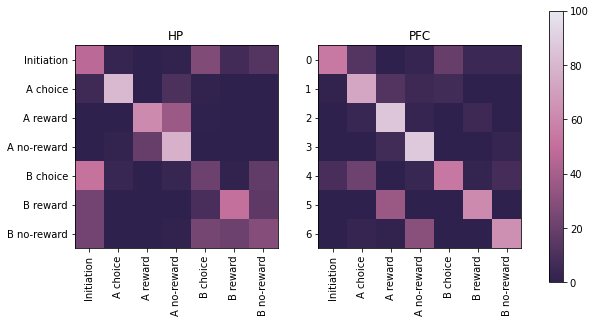

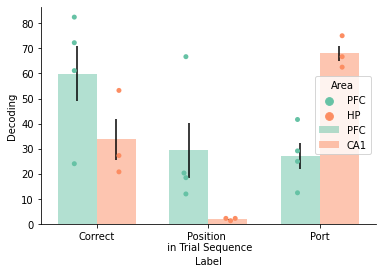

In [22]:
# plot fig 3F, G
plot(HP, PFC)